In [107]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.pipeline import make_pipeline
import os

# skimage
import skimage
import skimage.color
import skimage.transform
import skimage.feature
import skimage.io

In [108]:
from sklearn.base import BaseEstimator, TransformerMixin

class rgb2gray_transform(BaseEstimator,TransformerMixin):
    import skimage.color
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return np.array([skimage.color.rgb2gray(x) for x in X])
    
    
class hogtransformer(BaseEstimator,TransformerMixin):
    import skimage.feature
    def __init__(self,orientations=9,pixels_per_cell=(8, 8),cells_per_block=(3, 3),):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        def local_hog(img):
            hog_features= skimage.feature.hog(img,orientations=self.orientations,
                                pixels_per_cell=self.pixels_per_cell,
                                cells_per_block=self.cells_per_block)
            
            return hog_features
        
        hfeatures = np.array([local_hog(x) for x in X])
        return hfeatures

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline

In [110]:
# pipeline model
image = skimage.io.imread('cat.jpg')
# transform image into 80 x 80
image_resize = skimage.transform.resize(image,(80,80))
image_scale = 255*image_resize
image_transform = image_scale.astype(np.uint8)
# rgb to gray
gray = skimage.color.rgb2gray(image_transform)
# hog feature
feature_vector = skimage.feature.hog(gray,
                              orientations=10,
                              pixels_per_cell=(8,8),cells_per_block=(2,2))

In [111]:
feature_vector

array([0.25269896, 0.14211721, 0.03983474, ..., 0.19567423, 0.21307558,
       0.13811837])

In [112]:
import pickle
# load the model
model = pickle.load(open('dsa_image_classification_sgd.pickle','rb'))
scaler = pickle.load(open('dsa_scaler.pickle','rb'))

In [113]:
feature_vector.shape

(3240,)

In [114]:
scalex = scaler.transform(feature_vector.reshape(1,-1))
result = model.predict(scalex)

In [115]:
result

array(['cat'], dtype='<U8')

In [116]:
# cal the probabilty 
decision_value = model.decision_function(scalex)

In [117]:
decision_value

array([[-159.61020779,   23.80230912, -100.11661323, -192.58005328,
         -78.30727722, -141.07798841, -198.33429829, -184.09749174,
        -155.4953233 , -132.27490144,  -83.59154785, -206.45538075,
         -80.97982818, -125.55698991, -118.6150512 , -150.75466487,
         -89.49989647, -180.18112585, -100.66977532,  -87.59293734]])

In [118]:
model.classes_

array(['bear', 'cat', 'chicken', 'cow', 'deer', 'dog', 'duck', 'eagle',
       'elephant', 'human', 'lion', 'monkey', 'mouse', 'natural', 'panda',
       'pigeon', 'rabbit', 'sheep', 'tiger', 'wolf'], dtype='<U8')

In [119]:
labels = model.classes_

In [120]:
decision_value = decision_value.flatten()

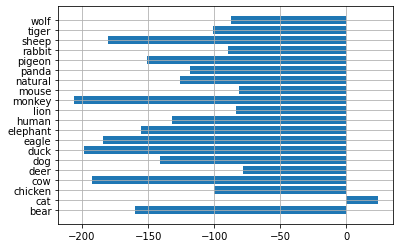

In [121]:
plt.barh(labels,decision_value)
plt.grid()

In [96]:
# cal. z score
z = scipy.stats.zscore(decision_value)
prob_value = scipy.special.softmax(z)
prob_value

array([0.02474219, 0.02800089, 0.04556916, 0.02114702, 0.01189936,
       0.03725854, 0.0938587 , 0.2928258 , 0.01241731, 0.02718769,
       0.00766622, 0.08625683, 0.00653059, 0.01880187, 0.07305718,
       0.11123441, 0.04158284, 0.02779584, 0.0273321 , 0.00483545])

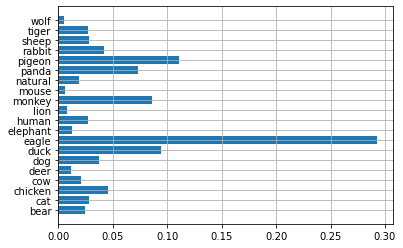

In [97]:
plt.barh(labels,prob_value)
plt.grid()

In [98]:
# top five probabilty values
top_5_prob_ind = prob_value.argsort()[::-1][:5]

In [99]:
top_5_prob_ind

array([ 7, 15,  6, 11, 14], dtype=int64)

In [100]:
top_labels = labels[top_5_prob_ind]
top_prob = prob_value[top_5_prob_ind]

In [101]:
top_prob,top_labels

(array([0.2928258 , 0.11123441, 0.0938587 , 0.08625683, 0.07305718]),
 array(['eagle', 'pigeon', 'duck', 'monkey', 'panda'], dtype='<U8'))

In [102]:
top_dict = dict()
for key,val in zip(top_labels,top_prob):
    top_dict.update({key:np.round(val,3)})

In [103]:
top_dict

{'eagle': 0.293,
 'pigeon': 0.111,
 'duck': 0.094,
 'monkey': 0.086,
 'panda': 0.073}

In [104]:
def pipeline_model(path,scaler_transform,model_sgd):
    # pipeline model
    image = skimage.io.imread(path)
    # transform image into 80 x 80
    image_resize = skimage.transform.resize(image,(80,80))
    image_scale = 255*image_resize
    image_transform = image_scale.astype(np.uint8)
    # rgb to gray
    gray = skimage.color.rgb2gray(image_transform)
    # hog feature
    feature_vector = skimage.feature.hog(gray,
                                  orientations=10,
                                  pixels_per_cell=(8,8),cells_per_block=(2,2))
    # scaling
    
    scalex = scaler_transform.transform(feature_vector.reshape(1,-1))
    result = model_sgd.predict(scalex)
    # decision function # confidence
    decision_value = model_sgd.decision_function(scalex).flatten()
    labels = model_sgd.classes_
    # probability
    z = scipy.stats.zscore(decision_value)
    prob_value = scipy.special.softmax(z)
    
    # top 5
    top_5_prob_ind = prob_value.argsort()[::-1][:5]
    top_labels = labels[top_5_prob_ind]
    top_prob = prob_value[top_5_prob_ind]
    # put in dictornary
    top_dict = dict()
    for key,val in zip(top_labels,top_prob):
        top_dict.update({key:np.round(val,3)})
    
    return top_dict

In [105]:
res = pipeline_model('eagle.jpg',scaler,model)
res

{'eagle': 0.293,
 'pigeon': 0.111,
 'duck': 0.094,
 'monkey': 0.086,
 'panda': 0.073}

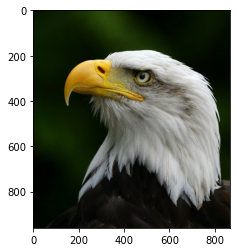

In [106]:
plt.imshow(image)